<a href="https://colab.research.google.com/github/omarbecerrasierra/MMA/blob/main/SegmentationSemanticMMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install segmentation_models_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 4.0 MB/s 
     |████████████████████████████████| 376 kB 31.7 MB/s 
     |████████████████████████████████| 58 kB 7.1 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=3a03cedd0e4e4a982a0d7714317242dfe68f01dae35c08d37f7cc9548b2714ce
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=b7913cd72ab781ba43b5022ca9ce4f7542d5ab635c293f4faf62102bf3b8be35
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [ ]:
import os
import glob
import cv2
import torch
import tqdm
import numpy as np 
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import albumentations as A
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils

from pathlib import Path
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.model_selection import train_test_split
from torch.utils.data.dataset import Dataset

# load Drive with tehe images for make segmentation
from google.colab import drive
drive.mount('/content/drive')

# 2 Create Datasets

In [ ]:
images = glob.glob("/content/drive/MyDrive/dataset/**/images/*.jpg")
masks = glob.glob("/content/drive/MyDrive/dataset/**/masks/*.png")
images.sort()
masks.sort()
df = pd.DataFrame()
df['images'] = images
df['masks'] = masks

# add height and width to df
l_height = []
l_width = []
n = df.shape[0]
for i in range(n):
    row = df.iloc[i]
    image_path = row['images']
    image = cv2.imread(image_path)
    image_shape = image.shape
    l_height.append(image_shape[0])
    l_width.append(image_shape[1])

df['height'] = l_height
df['width'] = l_width
df.head()

,images,masks,height,width
0,/content/drive/MyDrive/dataset/Tile 1/images/i...,/content/drive/MyDrive/dataset/Tile 1/masks/im...,644,797
1,/content/drive/MyDrive/dataset/Tile 1/images/i...,/content/drive/MyDrive/dataset/Tile 1/masks/im...,644,797
2,/content/drive/MyDrive/dataset/Tile 1/images/i...,/content/drive/MyDrive/dataset/Tile 1/masks/im...,644,797
3,/content/drive/MyDrive/dataset/Tile 1/images/i...,/content/drive/MyDrive/dataset/Tile 1/masks/im...,643,797
4,/content/drive/MyDrive/dataset/Tile 1/images/i...,/content/drive/MyDrive/dataset/Tile 1/masks/im...,643,797


# Train, Test Split

In [ ]:
df_train_valid, test_df = train_test_split(df, test_size=0.1, random_state=42)
train_df, valid_df = train_test_split(df_train_valid, test_size=0.2, random_state=42)

# Pipeline for the Preprocessing

In [ ]:
class MultiClassSegDataset(Dataset):
    
    def __init__(self, df, classes=None, transform=None,):
        self.df = df
        self.classes = classes
        self.transform = transform
        self.BGR_classes = {'Water' : [41, 169, 226],
                            'Land' : [246,  41, 132],
                            'Road' : [228, 193, 110],
                            'Building' : [152,  16,  60], 
                            'Vegetation' : [58, 221, 254],
                            'Unlabeled' : [155, 155, 155]
                            } # in BGR, because cv2 reads channels in that order

        self.bin_classes = ['Water', 'Land', 'Road', 'Building', 'Vegetation', 'Unlabeled']

    def __getitem__(self, idx):
        
        image_name = self.df.iloc[idx, 0]
        mask_name = self.df.iloc[idx, 1]
        image = cv2.imread(image_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_name, cv2.IMREAD_UNCHANGED)
        image = image.astype('uint8')

        cls_mask = np.zeros(mask.shape)
        cls_mask[mask == self.BGR_classes['Water']] = self.bin_classes.index('Water')
        cls_mask[mask == self.BGR_classes['Land']] = self.bin_classes.index('Land')
        cls_mask[mask == self.BGR_classes['Road']] = self.bin_classes.index('Road')
        cls_mask[mask == self.BGR_classes['Building']] = self.bin_classes.index('Building')
        cls_mask[mask == self.BGR_classes['Vegetation']] = self.bin_classes.index('Vegetation')
        cls_mask[mask == self.BGR_classes['Unlabeled']] = self.bin_classes.index('Unlabeled')
        cls_mask = cls_mask[:,:,0]

        if self.transform is not None:
            transformed = self.transform(image=image, mask=cls_mask)
            image = transformed["image"]
            cls_mask = transformed["mask"]
            image = torch.from_numpy(image)
            cls_mask = torch.from_numpy(cls_mask)
            image = image.permute(2, 0, 1)
            image = image.float()/255
            cls_mask = cls_mask.long().unsqueeze(0)
        else: 
            image = torch.from_numpy(image)
            cls_mask = torch.from_numpy(cls_mask)
            image = image.permute(2, 0, 1)
            image = image.float()/255
            cls_mask = cls_mask.long().unsqueeze(0)
        return image, cls_mask  
        
    def __len__(self):
        return len(self.df)

# Augmentations an transformations of the dataset

In [ ]:
img_size = 256
MULTICLASS_MODE: str = "multiclass"
ENCODER = "efficientnet-b3" 
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['Water', 'Land', 'Road', 'Building', 'Vegetation', 'Unlabeled']
ACTIVATION = None
DEVICE = 'cuda'
n_epochs = 100

In [ ]:
test_transform = A.Compose(
    [A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=4), A.Resize(img_size, img_size),]
)

train_transform = A.Compose(
    [
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=4),
        A.Resize(img_size, img_size),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.MedianBlur(blur_limit=3, always_apply=False, p=0.1),
    ]
)

trainDS = MultiClassSegDataset(train_df, classes=CLASSES, transform=train_transform)
validDS = MultiClassSegDataset(valid_df, classes=CLASSES, transform=test_transform)

In [ ]:
trainDL = torch.utils.data.DataLoader(trainDS, batch_size=2, shuffle=True, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None)
validDL =  torch.utils.data.DataLoader(validDS, batch_size=2, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None)

# Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
model = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = ENCODER_WEIGHTS,
        in_channels = 3,
        classes = 6,
        activation = None
)
total_params = sum(p.numel() for p in model.parameters())
loss = smp.losses.DiceLoss(mode=MULTICLASS_MODE)
loss.__name__ = 'Dice_loss'
optimizer = optim.Adam(params=model.parameters(), lr=0.003)
metrics = []

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth


  0%|          | 0.00/47.1M [00:00<?, ?B/s]

# Load DataLoader Epoch

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss,
    metrics= metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True
)

# Train model

In [ ]:
# Train model for n_epochs
best_loss = np.Inf
l_train_loss = []
l_valid_loss = []

for i in range(0, n_epochs):
    train_logs = train_epoch.run(trainDL)
    valid_logs = valid_epoch.run(validDL)

    train_loss = train_logs[loss.__name__]
    valid_loss = valid_logs[loss.__name__]

    l_train_loss.append(train_loss)
    l_valid_loss.append(valid_loss)

    if valid_loss < best_loss:
        torch.save(model.state_dict(), './best_model.pth') 
        print('SAVED-MODEL')
        best_loss = valid_loss

0
valid: 100%|██████████| 7/7 [00:07<00:00,  1.06s/it, Dice_loss - 0.6929]
SAVED-MODEL
1
valid: 100%|██████████| 7/7 [00:02<00:00,  2.46it/s, Dice_loss - 0.8889]
2
valid: 100%|██████████| 7/7 [00:02<00:00,  2.50it/s, Dice_loss - 0.9255]
3
valid: 100%|██████████| 7/7 [00:02<00:00,  2.49it/s, Dice_loss - 0.9239]
4
valid: 100%|██████████| 7/7 [00:02<00:00,  2.51it/s, Dice_loss - 0.908]
5
valid: 100%|██████████| 7/7 [00:02<00:00,  2.50it/s, Dice_loss - 0.7584]
6
valid: 100%|██████████| 7/7 [00:04<00:00,  1.49it/s, Dice_loss - 0.5775]
SAVED-MODEL
7
valid: 100%|██████████| 7/7 [00:02<00:00,  2.46it/s, Dice_loss - 0.5669]
SAVED-MODEL
8
valid: 100%|██████████| 7/7 [00:02<00:00,  2.47it/s, Dice_loss - 0.5543]
SAVED-MODEL
9
valid: 100%|██████████| 7/7 [00:02<00:00,  2.48it/s, Dice_loss - 0.546]
SAVED-MODEL
10
valid: 100%|██████████| 7/7 [00:04<00:00,  1.54it/s, Dice_loss - 0.5233]
SAVED-MODEL
11
valid: 100%|██████████| 7/7 [00:03<00:00,  1.88it/s, Dice_loss - 0.6149]
12
valid: 100%|██████████| 7

In [ ]:
# Load the best model in train
model.load_state_dict(torch.load('./best_model.pth'))

<All keys matched successfully>

# Transformation in the test set

In [ ]:
# Making transformations in the test set
test = test_df 
testDS = MultiClassSegDataset(test, classes=CLASSES, transform=test_transform)
testDL =  torch.utils.data.DataLoader(testDS, batch_size=8, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None)
           
test_epoch = smp.utils.train.ValidEpoch(
    model=model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(testDL)
print(logs)

valid: 100%|██████████| 1/1 [00:01<00:00,  1.12s/it, Dice_loss - 0.3703]
{'Dice_loss': 0.3702702522277832}


In [ ]:
# Visualize images, masks, and predictions 

def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 10))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

def relevant_metrics(ground_truth, prediction):
    truth = ground_truth.numpy().flatten()
    predict = prediction.flatten() 
    p = precision_score(truth, predict, average='weighted')
    r = recall_score(truth, predict, average='weighted')
    f1 = f1_score(truth, predict, average='weighted')
    js = jaccard_score(truth, predict,average='weighted')
    return p, r, f1, js

def real_mask(DS, input_mask, n_classes):
    h = input_mask.shape[0]
    w = input_mask.shape[1]
    real_mask = np.zeros((h, w, 3))

    for cl in range(n_classes):
        cl_name = DS.bin_classes[cl]
        gbr = np.array(DS.BGR_classes[cl_name])
        real_mask[input_mask == cl] = gbr[::-1] / 255
    return real_mask

def plot_class_colors(n):
    n = len(trainDS.bin_classes)
    plt.figure(figsize=(10, 5))
    plt.subplots_adjust(hspace=1, wspace=0.5)
    plt.suptitle("Classes", fontsize=18, y=0.7)
    data = trainDS.bin_classes

    for n, cl in enumerate(data):
        pic = np.zeros((50,50, 3))
        cl_name = trainDS.bin_classes[n]
        gbr = trainDS.BGR_classes[cl_name]
        pic[:, :, 0] = gbr[2] / 255
        pic[:, :, 1] = gbr[1] / 255
        pic[:, :, 2] = gbr[0] / 255
        ax = plt.subplot(1, 6, n+1)
        ax.set_title(cl_name)
        ax.imshow(pic)

# Get predictions and metrics for the test set

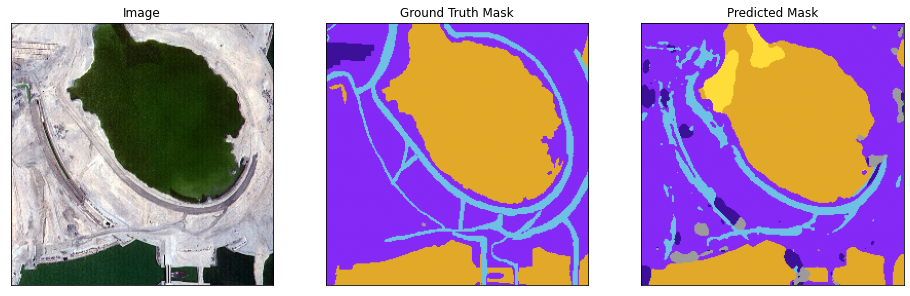

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision: 0.8505169942587801
recall: 0.8040618896484375
f1: 0.825294777157291
jaccard: 0.7322994057768639


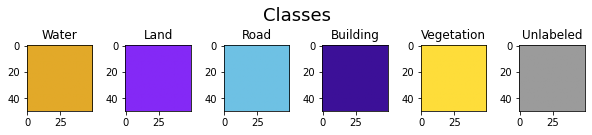

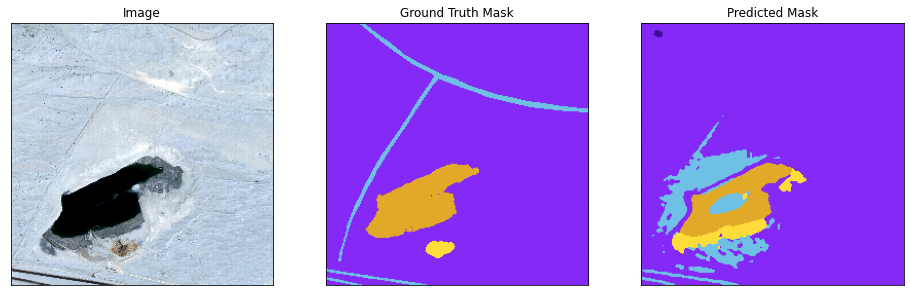

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision: 0.9346712551641833
recall: 0.8818359375
f1: 0.9057625884938287
jaccard: 0.8497148142751748


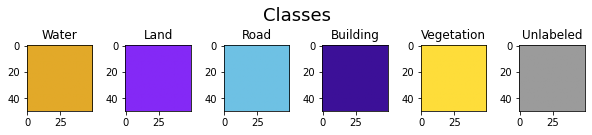

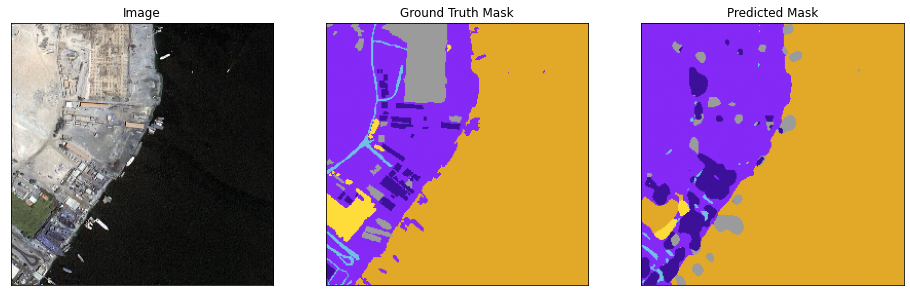

precision: 0.8138706635994519
recall: 0.82464599609375
f1: 0.8099108338741176
jaccard: 0.7441349332549019


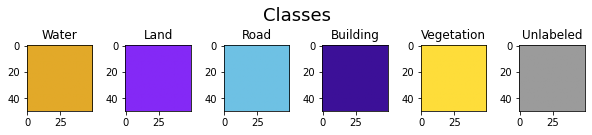

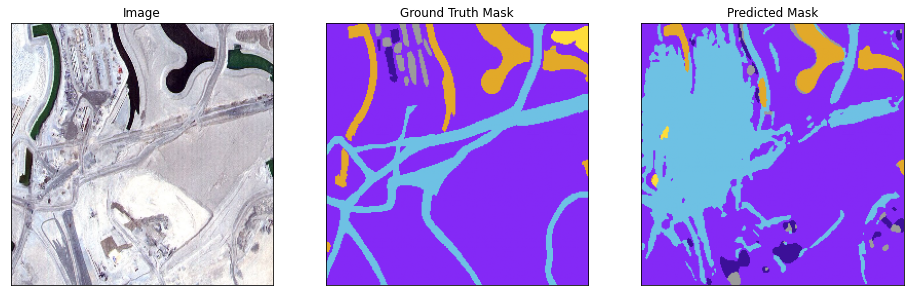

precision: 0.7944785028229676
recall: 0.666168212890625
f1: 0.7043206124099956
jaccard: 0.5661759198785925


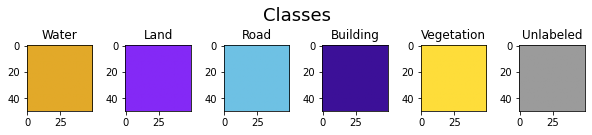

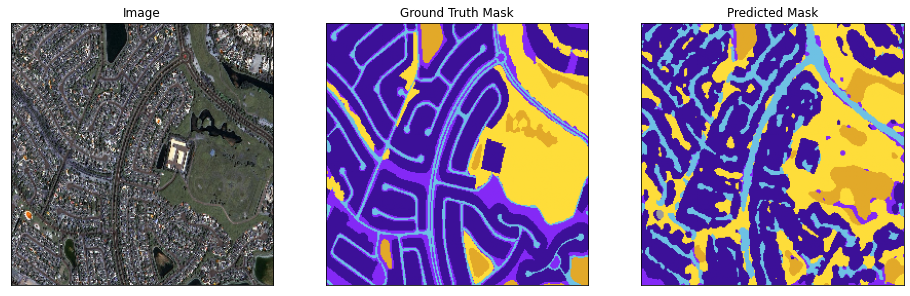

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision: 0.6512461904897408
recall: 0.664947509765625
f1: 0.6362899476400609
jaccard: 0.5101485849558534


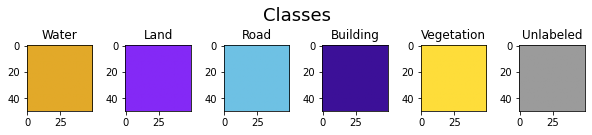

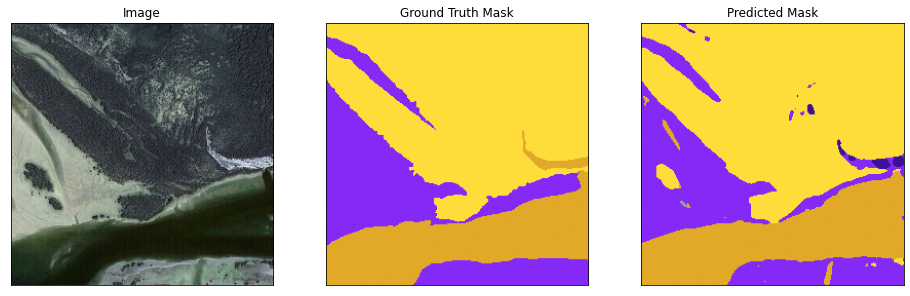

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision: 0.9486448434833477
recall: 0.942779541015625
f1: 0.9452046074735806
jaccard: 0.8982082911055291


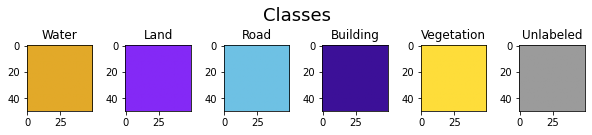

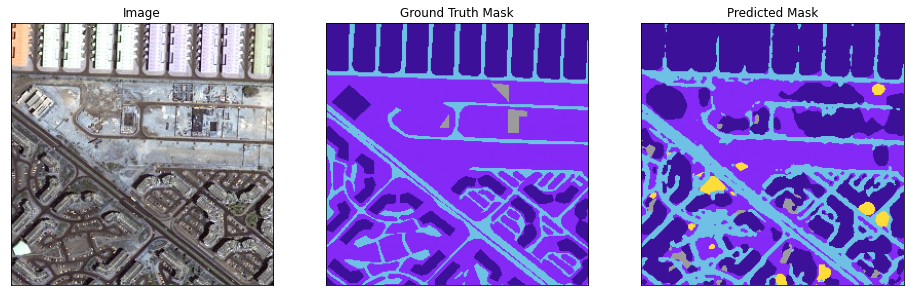

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision: 0.7615848927187987
recall: 0.656219482421875
f1: 0.6534399568966288
jaccard: 0.4887931642429624


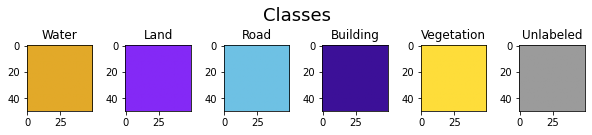

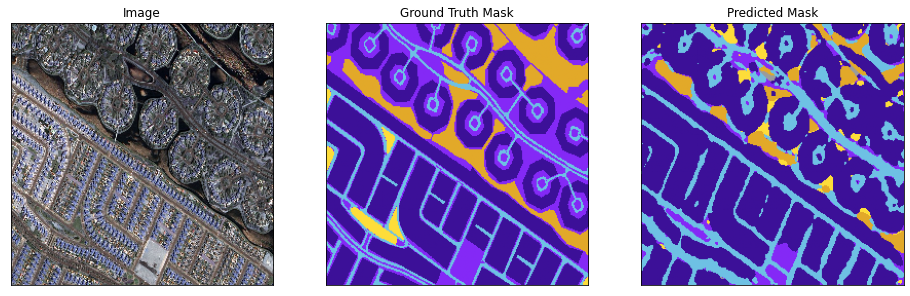

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision: 0.6998076656810309
recall: 0.6621551513671875
f1: 0.6076144500484767
jaccard: 0.48097512499330947
################################################################################
############################## Summary ##############################
################################################################################
Precision : 0.8068526260272876
Recall : 0.7628517150878906
F1: 0.7609797217492476
Jaccard : 0.6588062798103984


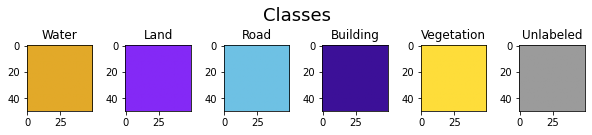

In [ ]:
p_final = []
r_final = []
f1_final = []
js_final = []

for i in range(len(testDS)):
    n = i
    
    image_vis = testDS[n][0].permute(1,2,0)
    image_vis = image_vis.numpy()*255
    image_vis = image_vis.astype('uint8')
    image, gt_mask = testDS[n]
    gt_mask = gt_mask.squeeze()
    x_tensor = image.to(DEVICE).unsqueeze(0)
    pr_mask = model.predict(x_tensor)
    m = nn.Softmax(dim=1)
    pr_probs = m(pr_mask)              
    pr_mask = torch.argmax(pr_probs, dim=1).squeeze(1)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    real_gt_mask = real_mask(DS=testDS, input_mask=gt_mask, n_classes=6)
    real_pr_mask = real_mask(DS=testDS, input_mask=pr_mask, n_classes=6)
    visualize(
        image=image_vis,
        ground_truth_mask=real_gt_mask, 
        predicted_mask=real_pr_mask
    )

    plot_class_colors(n=len(CLASSES))
    p, r, f1, js = relevant_metrics(ground_truth=gt_mask, prediction=pr_mask)

    p_final.append(p)
    r_final.append(r)
    f1_final.append(f1)
    js_final.append(js)

    print(f"precision: {p}")
    print(f"recall: {r}")
    print(f"f1: {f1}")
    print(f"jaccard: {js}")
print('#'*80)
print('#'*30, 'Summary', '#'*30)
print('#'*80)
print(f"Precision : {np.mean(p_final)}")
print(f"Recall : {np.mean(r_final)}")
print(f"F1: {np.mean(f1_final)}")
print(f"Jaccard : {np.mean(js_final)}")